<a href="https://colab.research.google.com/github/tocom242242/pytorch-cifar10-simple-example/blob/main/gradcam_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 20.5 MB/s 


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import numpy as np
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
from tqdm import tqdm

BICUBIC = InterpolationMode.BICUBIC

Files already downloaded and verified
Files already downloaded and verified


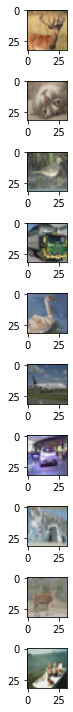

In [ ]:
def get_loaders(batch_size):
    ds = torchvision.datasets.CIFAR10
    transform = transforms.Compose([
        transforms.Resize(32, interpolation=BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    trainset = ds(root='data', train=True, download=True, transform=transform)
    indices = torch.arange(5000) 
    trainset = Subset(trainset, indices)

    n_samples = len(trainset)
    train_size = int(len(trainset) * 0.9)
    val_size = n_samples - train_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                drop_last=False)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                drop_last=False)

    testset = ds(root='data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                                drop_last=False)
    return train_loader, val_loader, test_loader



def plot_ds(dataset, row=10, col=1, figsize=(20,10)):
    fig_img, ax_img = plt.subplots(row, col, figsize=figsize, tight_layout=True)
    plt.figure()
    for i in range(row):
        img1,_ = dataset[i]
        img1 = denormalization(img1)
        img1 = np.squeeze(img1)
        ax_img[i].imshow(img1)
        
    fig_img.savefig("data_sample.png", dpi=100)
    plt.close()

def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

def denormalization(x):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    x = inverse_normalize(x, mean, std)
    x = x.cpu().detach().numpy()
    # x = (x.transpose(1, 2, 0)).astype(np.uint8)
    x = (x.transpose(1, 2, 0) * 255.0).astype(np.uint8)

    return x

train_loader, val_loader, test_loader = get_loaders(batch_size=32)
plot_ds(train_loader.dataset)

In [ ]:

class AverageMeter(object):
    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ClassifierModel(torch.nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()

        # 畳み込み層
        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=128,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.Flatten()
        )
        # 全結合層
        self.mlp_layers = torch.nn.Sequential(
            torch.nn.Linear(256, 50),
            torch.nn.ReLU(True),
            torch.nn.Linear(50, 10),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.backbone(x)
        y = self.mlp_layers(x)
        return y



In [ ]:
# 学習など
model = ClassifierModel()
epochs = 10
train_loss = AverageMeter("train_loss")
train_acc = AverageMeter("train_acc")
val_loss = AverageMeter("val_loss")
val_acc = AverageMeter("val_acc")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=30, gamma=0.1
)

min_loss = np.inf
for epoch in tqdm(range(epochs)):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs.squeeze(), y)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted==y).sum().item()/y.size(0)
        train_loss.update(loss.data)
        train_acc.update(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    for x, y in val_loader:
        outputs = model(x)
        loss = criterion(outputs.squeeze(), y)
        val_loss.update(loss.data)

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted==y).sum().item()/y.size(0)
        val_acc.update(accuracy)

    if val_loss.avg < min_loss:
        print("save model")
        torch.save(model.state_dict(), "model.pth")
        min_loss = val_loss.avg

    print(
        "[epoch :{:.1f} train_loss: {} val_loss: {} train_acc: {} val_acc: {}] ".format(
            epoch, train_loss.avg, val_loss.avg,
            train_acc.avg, val_acc.avg
        )
    )
    scheduler.step()
    train_loss.reset()
    val_loss.reset()

model.load_state_dict(torch.load("model.pth"))

 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

save model
[epoch :0.0 train_loss: 2.2751195430755615 val_loss: 2.2351632118225098 train_acc: 0.21538120567375885 val_acc: 0.273046875] 


 20%|██        | 2/10 [00:14<01:02,  7.75s/it]

save model
[epoch :1.0 train_loss: 2.2145583629608154 val_loss: 2.1822266578674316 train_acc: 0.2441489361702128 val_acc: 0.28652343750000003] 


 30%|███       | 3/10 [00:20<00:47,  6.72s/it]

save model
[epoch :2.0 train_loss: 2.1643388271331787 val_loss: 2.143458366394043 train_acc: 0.2673463356973995 val_acc: 0.30247395833333335] 


 40%|████      | 4/10 [00:25<00:35,  5.98s/it]

save model
[epoch :3.0 train_loss: 2.126023530960083 val_loss: 2.1183855533599854 train_acc: 0.29225398936170216 val_acc: 0.31845703125] 


 50%|█████     | 5/10 [00:29<00:27,  5.57s/it]

save model
[epoch :4.0 train_loss: 2.0935466289520264 val_loss: 2.0983242988586426 train_acc: 0.31231382978723404 val_acc: 0.32937500000000003] 


 60%|██████    | 6/10 [00:34<00:21,  5.34s/it]

save model
[epoch :5.0 train_loss: 2.065131902694702 val_loss: 2.0884368419647217 train_acc: 0.33019355791962174 val_acc: 0.33971354166666673] 


 70%|███████   | 7/10 [00:39<00:15,  5.19s/it]

save model
[epoch :6.0 train_loss: 2.04079270362854 val_loss: 2.073014736175537 train_acc: 0.34697315096251263 val_acc: 0.3469866071428572] 


 80%|████████  | 8/10 [00:44<00:10,  5.09s/it]

[epoch :7.0 train_loss: 2.0193135738372803 val_loss: 2.073711633682251 train_acc: 0.3620345744680851 val_acc: 0.353369140625] 


 90%|█████████ | 9/10 [00:49<00:05,  5.02s/it]

save model
[epoch :8.0 train_loss: 2.000230073928833 val_loss: 2.0698204040527344 train_acc: 0.37620173364854215 val_acc: 0.3577690972222223] 


100%|██████████| 10/10 [00:54<00:00,  5.44s/it]

save model
[epoch :9.0 train_loss: 1.977609634399414 val_loss: 2.0513086318969727 train_acc: 0.39010638297872335 val_acc: 0.36230468750000006] 


<All keys matched successfully>

In [ ]:
# 評価
# model.eval()
# accuracy = 0
# num_total = 0
# for x, y in test_loader:
#     outputs = model(x)
#     _, predicted = torch.max(outputs.data, 1)
#     accuracy += (predicted==y).sum().item()
#     num_total += y.size(0)

# accracy = accuracy/num_total
# print(f"accuracy:{accracy}")

Files already downloaded and verified


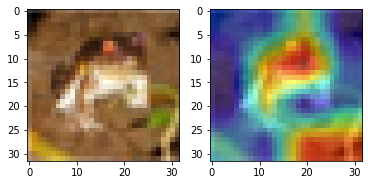

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
model.eval()

ds = torchvision.datasets.CIFAR10
input_transform = transforms.Compose([
    transforms.Resize(32, interpolation=BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img_transform = transforms.Compose([
    transforms.Resize(32, interpolation=BICUBIC),
    transforms.ToTensor(),
])

trainset = ds(root='data', train=True, download=True)
img, label = trainset[0]
input_img = input_transform(img)
img = img_transform(img)

# target_layers = [model.backbone.layer4[-1]]
target_layers = [model.backbone[-3]]
cam = GradCAM(
    model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()
)
grayscale_cam = cam(
    input_tensor=input_img.unsqueeze(0),
    targets=[ClassifierOutputTarget(label)],
)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img.permute(1, 2, 0).numpy())
ax[1].imshow(visualization)


In [ ]:
a,b = torch.max(model(input_img.unsqueeze(0).to("cuda")),1)
print(b)
# model(input_img.unsqueeze(0))

tensor([1], device='cuda:0')
